# Двухфакторный дисперсионный анализ

Two-way analysis of variable - позволяет определить взаимосвязь зависимой переменной не с одним фактором, а с двумя и выявить эффект взаимодействия на переменную отклика комбинации этих факторов.
Требования к данным и допущения: \

1) Нормальность распределения зависимой перменной в каждой из групп
2) Гомогенность дисперсий

Первое требование к нормальности данных можно проверить простроя графий qq-plot, провести тест Шапиро-Уилка, критерием Колмогорова
Второе требование к гомогенности можно проверить проведя тест Левена. \

Ниже приведен алгоритм реализации двухфакторного дисперсионного анализа с проверкой данных на нормальность распределения и гомогенность дисперсии

In [17]:
import math
from scipy import stats
import numpy as np
import random
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from pylab import rcParams

rcParams['figure.figsize'] = 10, 6
PATH = "/Users/daria/stepikcourse/"

In [16]:
def twowayanova(frame):
    
    fac1_column = frame[frame.columns[1]] # series по столбцу первого фактора 
    fac2_column = frame[frame.columns[2]] # series по столбцу второго фактора 
    groups_list = []
    flag = 0
    dictrib_flag = False 
    dispersion_flag = False 

    for i in fac1_column.unique(): # итерация по уникальным значениям 1-ого фактора 
        
        for j in fac2_column.unique():  # итерация по уникальным значениям 2-ого фактора 
            
            a = frame[((fac1_column == i) & (fac2_column == j))][frame.columns[0]]
            stat, p = stats.shapiro(a)
            groups_list.append(a)
            if p > 0.05:
                flag = flag + 1
                print(f'Зависимая переменна группы {flag} распределена нормально, p-val = {round(p, 2)}')

    if flag == 4:
        dictrib_flag = True   
        
    if len(a) == 4:          
        stat, p = stats.levene(groups_list[0], groups_list[1], groups_list[2], groups_list[3], center='median')
    elif len(a) == 6:    
        stat, p = stats.levene(groups_list[0], groups_list[1], groups_list[2], groups_list[3], groups_list[4], groups_list[5], center='median')
        
    if p > 0.05:
        print(f'Дисперсии равны, p-val = {round(p, 2)}')
        dispersion_flag = True 
        
    if dictrib_flag == True and dispersion_flag == True:
        
        ssb1 = 0 # переменная межгрупповой суммы квадратов первого фактора
        ssb2 = 0 # переменная межгрупповой суммы квадратов второго фактора
        ssw = 0 # переменная внутригрупповой суммы квадратов второго фактора

        df = [] # список степеней свобод групп
        ss = [] # список сумм квадратов
        pivot_dict = {} # сводный словарь с данными о спетенях свободы, сумм квадратов, MS, F-значений, p-value

        var_column = frame[frame.columns[0]] # series по столбцу зависимой переменной 

        comm_mean = sum(var_column) / len(var_column) # общее среднее по всем группам 

        for i in frame.columns[1::]: # итерация по факторам 

            for j in frame[i].unique(): # итерация по уникальным значениям i-ого фактора 
                depend_var = frame[frame[i] == j][frame.columns[0]] # series зависимой переменной j-ой группы i-ого фактора

                if i == frame.columns[1]:
                    ssb1 = ssb1 + sum([(depend_var.mean() - comm_mean) ** 2 for k in depend_var])
                    dffac1 = len(frame[i].unique()) - 1 # степень свободы первого фактора 
                else:
                    ssb2 = ssb2 + sum([(depend_var.mean() - comm_mean) ** 2 for k in depend_var])
                    dffac2 = len(frame[i].unique()) - 1 # степень свободы второго фактора

        for i in fac1_column.unique(): # итерация по уникальным значениям 1-ого фактора 

            for j in fac2_column.unique():  # итерация по уникальным значениям 2-ого фактора 
                a = frame[((fac1_column == i) & (fac2_column == j))][frame.columns[0]] # series подгруппы зависимой переменной j-ой группы 2-ого фактора и i-ого группы 1-ого фактора
                ssw = ssw + sum([(a.mean() - k) ** 2 for k in a])
                dfwithin = frame.shape[0] - (len(fac1_column.unique()) + len(fac2_column.unique())) # внутригрупповая степень свободы
        sst = sum([(i - var_column.mean()) ** 2 for i in var_column]) # общая сумма квадратов 
        ssboth = sst - ssw - ssb1 - ssb2 # сумма квадратов взаимодействия двух факторов
        ss.extend([ssb1, ssb2, ssboth, ssw]) 

        dfborh = dffac1 * dffac2
        df.extend([dffac1, dffac2, dfborh, dfwithin])

        ms = [a / b for a, b in zip(ss, df)] # вычисление mean square

        f_score = [a / ms[3] for a in ms[:3]] # вычисление F критерия 

        p = stats.f.sf(f_score, df[:3], 60) # вычисление p-value 

        columns = ['index', 'df', 'Sum sq', 'Mean sq', 'F value', 'Pr(>F)']
        index = [frame.columns[1], frame.columns[2], f'{frame.columns[1]}:{frame.columns[2]}', 'Residual']

        temp = list([index, df, ss, ms, f_score, p]) # объединение в обший список 

        for i, j in zip(columns, temp):  
            pivot_dict[i] = j

        pivot_data = pd.DataFrame(pivot_dict.values(), pivot_dict.keys()).T
        pivot_data.set_index('index')
        sns.pointplot(x=fac1_column, y=var_column, hue=fac2_column, data=frame, dodge=True, linestyles=['', ''])  
        
    else:
        print(f'Требования к распределению данных или гомогенности дисперсий групп не выполнены')
        
    return pivot_data

Задача: исследовать влияние инъекции некого гормона на концертрацию кальция в плазме у птиц разного пола \
Загрузим набор данных

In [18]:
hormone_inject = pd.read_csv(PATH + 'birds.csv')
hormone_inject.head()
# hormone: 1 - инекция, 0 - отсутствие инъекции 
# sex: 1 - мужской, 0 - женский

,var4,hormone,sex
0,17.859039,1,1
1,20.842343,1,1
2,19.318099,1,1
3,20.064451,1,1
4,17.620316,1,1


Зависимая переменна группы 1 распределена нормально, p-val = 0.46
Зависимая переменна группы 2 распределена нормально, p-val = 0.87
Зависимая переменна группы 3 распределена нормально, p-val = 0.1
Зависимая переменна группы 4 распределена нормально, p-val = 0.42
Дисперсии равны, p-val = 0.42


,index,df,Sum sq,Mean sq,F value,Pr(>F)
0,hormone,1,0.847472,0.847472,0.086528,0.769653
1,sex,1,0.119762,0.119762,0.012228,0.912318
2,hormone:sex,1,89.483384,89.483384,9.13639,0.003682
3,Residual,60,587.650394,9.794173,None,None


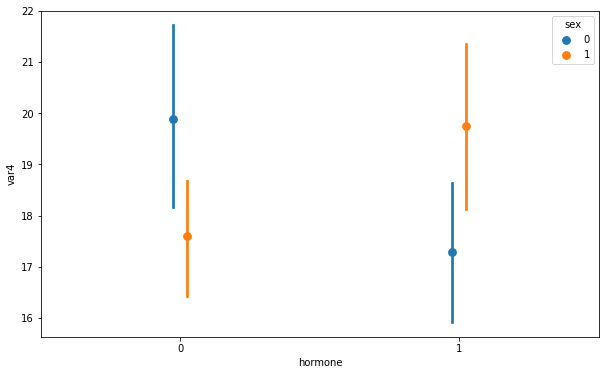

In [13]:
twowayanova(hormone_inject)

Вывод: фактор инъекции и пола по отдельности не оказал статистически значимого влияния на уровень кальция в плазме. Однако совокупность факторов оказала значимое влияние на зависимую переменную

Задача: исследовать влияние инъекции некого препарата на величину экспрессии генов в двух возврастных группах. Загрузим набор данных

In [19]:
gene_expression = pd.read_csv(PATH + 'atherosclerosis.csv')

Зависимая переменна группы 1 распределена нормально, p-val = 0.3
Зависимая переменна группы 2 распределена нормально, p-val = 0.12
Зависимая переменна группы 3 распределена нормально, p-val = 1.0
Зависимая переменна группы 4 распределена нормально, p-val = 0.63
Дисперсии равны, p-val = 0.63


,index,df,Sum sq,Mean sq,F value,Pr(>F)
0,age,1,197.452754,197.452754,7.449841,0.008313
1,dose,1,16.912241,16.912241,0.638094,0.427552
2,age:dose,1,0.927077,0.927077,0.034978,0.852272
3,Residual,60,1590.257424,26.50429,None,None


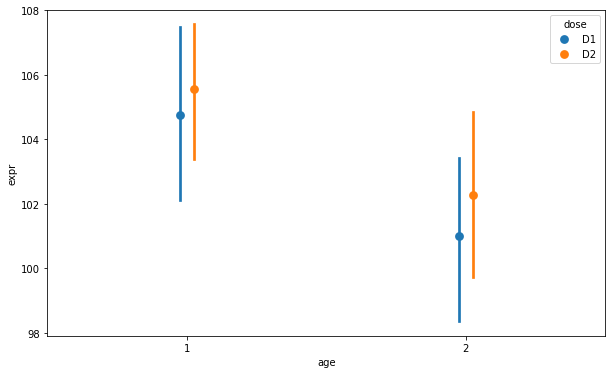

In [15]:
twowayanova(gene_expression)

Вывод: фактор возраста оказал статистически значимое влияния на уровень экспресси гена. Pr=0.008313